In [1]:
import numpy as np
import matplotlib.pyplot as plt

from csc.utils import *
from csc.dictionary import CSCDictionary
from csc.main import conv_multipath_matching_pursuit


# Atom parameters
bmin = 0.005
bmax = 0.06
b_step = 0.005
b_values = np.arange(bmin, bmax, b_step)

ymin = 0.010
ymax = 0.036
y_step = 0.002
y_values = np.arange(ymin, ymax, y_step)

s_values = [1]

dictionary = CSCDictionary.from_values(b_values, y_values, s_values)
print('The dictionary has {} different atoms'.format(len(dictionary)))

The dictionary has 143 different atoms


### Create a random signal with atoms from the dictionary

1. Define the signal parameters

In [2]:
NB_ATOMS = 3
SIGNAL_SNR = 10
SIGNAL_LENGTH = int(1.5*dictionary.getAtomsLength())

2. Generate a random signal with the atoms from the dictionary

In [3]:
signal, true_atoms_info = dictionary.generateTestSignal(
    signal_length=SIGNAL_LENGTH,
    sparsity_level=NB_ATOMS,
    snr_level=SIGNAL_SNR
)

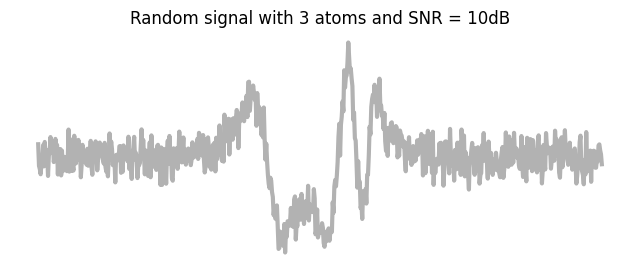

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(signal, color='k', lw=3, alpha=0.3)
ax.set_title('Random signal with {} atoms and SNR = {}dB'.format(NB_ATOMS, SIGNAL_SNR))
plt.axis('off')
plt.show()

3. Define a number of branches to explore in the search tree

In [5]:
NB_BRANCHES = 9

4. Execute the convolutional multipath matching pursuit algorithm to obtain the signal reconstruction and the atoms informations

In [6]:
approx, conv_mmp_infos = conv_multipath_matching_pursuit(
    signal=signal,
    dictionary=dictionary,
    nb_atoms=NB_ATOMS,
    nb_mmp_branches=NB_BRANCHES
)

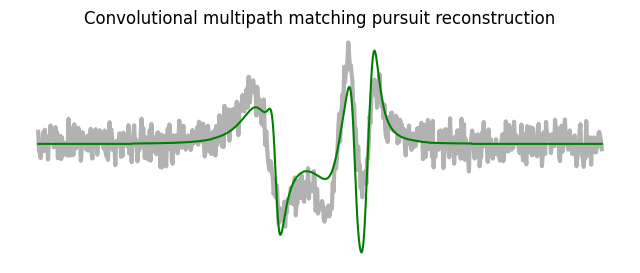

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(signal, color='k', lw=3, alpha=0.3)
ax.plot(approx, color='g', lw=1.5)
ax.set_title('Convolutional multipath matching pursuit reconstruction')
plt.axis('off')
plt.show()

In [13]:
POSITION_TOLERANCE = 5
CORRELATION_TOLERANCE = 0.95
true_positives = computeMaxTruePositives(dictionary=dictionary,
                                         signal_length=SIGNAL_LENGTH,
                                         true_atoms=true_atoms_info,
                                         approx_atoms=conv_mmp_infos,
                                         pos_err_threshold=POSITION_TOLERANCE,
                                         corr_err_threshold=CORRELATION_TOLERANCE
                                         )

print('True positives : {}/{}'.format(true_positives, NB_ATOMS))

True positives : 2/3
